In [1]:
! pip3 -q install optax equinox

     |████████████████████████████████| 145 kB 29.9 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 85 kB 3.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.2 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.


In [2]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 47 (delta 17), reused 41 (delta 14), pack-reused 0
Unpacking objects: 100% (47/47), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [3]:
from misc import utils, Chebyshev

from integrators import RK4, Explicit_Euler, Implicit_Euler
from sdc_integrators import Explicit_Euler as Explicit_Euler_c
from sdc_integrators import Implicit_Euler as Implicit_Euler_c
from sdc_integrators import Implicit_Euler as Implicit_Euler_cJ

from architectures import elementary_architectures, vanilla_PiNN

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import equinox as eqx

from jax import jit, config, random
from jax.lax import cond
config.update("jax_enable_x64", True)

%config InlineBackend.figure_format='retina'

# PiNN and ODE

Here I am interested in the problem

\begin{equation}
    \dot{u}(t) = F(u(t), t),\, u(t_0) = u_{0},\,u\in\mathbb{R}^{N_\text{eq}},\,t\in[t_0, t_1],
\end{equation}

so, naturally, the PiNN-style solution is to write

\begin{equation}
    u(t) = u_0 (t_1 - t) \big/ (t_1 - t_0) + N(t;w) (t - t_0) \big/ (t_1 - t_0).
\end{equation}

The derivative is easy to find with automatic differentiation

\begin{equation}
    \dot{u}(t) = (N(t;w) - u_0) \big/ (t_1 - t_0) + \dot{N}(t;w) (t - t_0) \big/ (t_1 - t_0).
\end{equation}

In [5]:
key = random.PRNGKey(22)
shapes = [1, 40, 2]
NN = elementary_architectures.smooth_feedforward(shapes, key)

learning_rate = 1e-3
optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(NN, eqx.is_array))

# Training

## Van der Pol (mildly stiff vector nonlinear ODE)

In [6]:
epsilon = 1.0
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

@jit
def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

N_points = 50
t0, t1 = 0.0, 1.0
T = [t0, t1]
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
t_uniform = jnp.linspace(t0, t1, N_points).reshape(-1, 1)
u0 = jnp.array([1.0, 3.0])

In [7]:
%timeit vanilla_PiNN.make_step(NN, t_uniform, u0, T, F, opt_state, optim)

2.96 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
1.35 * 20000 * 1e-3 / 60

0.45

In [9]:
loss = vanilla_PiNN.compute_loss(NN, t_uniform, u0, T, F)
history = [loss.item(), ]

for i in range(20000):
    loss, NN, opt_state = vanilla_PiNN.make_step(NN, t_uniform, u0, T, F, opt_state, optim)
    history.append(loss.item())

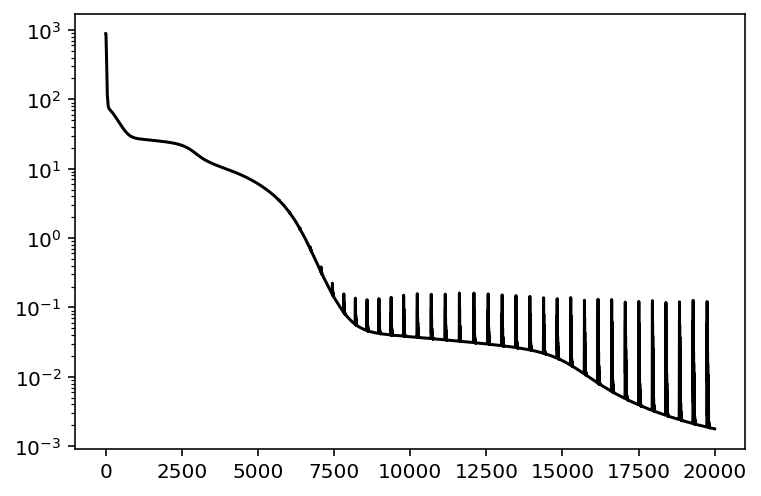

In [10]:
plt.yscale("log")
plt.plot(history, color="black");

### Predictions withing the interval

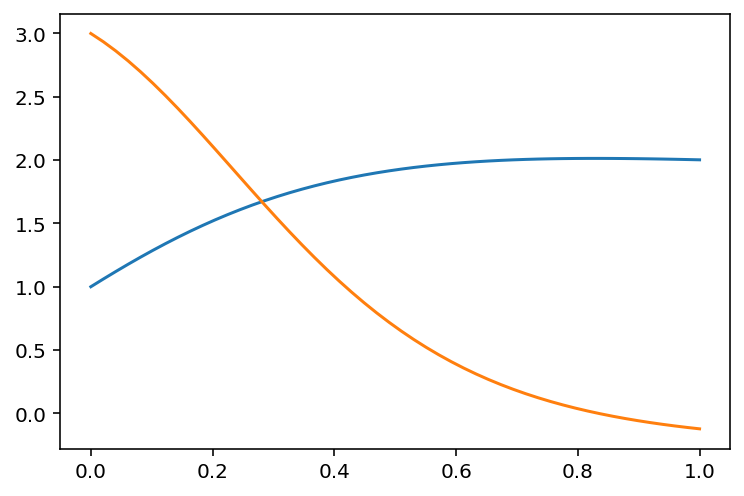

In [11]:
prediction = vanilla_PiNN.v_predict(NN, t_uniform, u0, T)

plt.plot(t_uniform, prediction);

In [12]:
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]

for i in range(30):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)

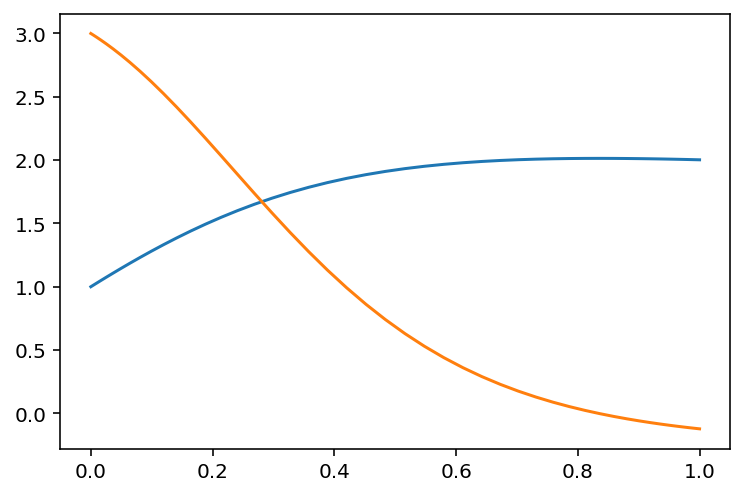

In [13]:
plt.plot(t, values);

### Extrapolation

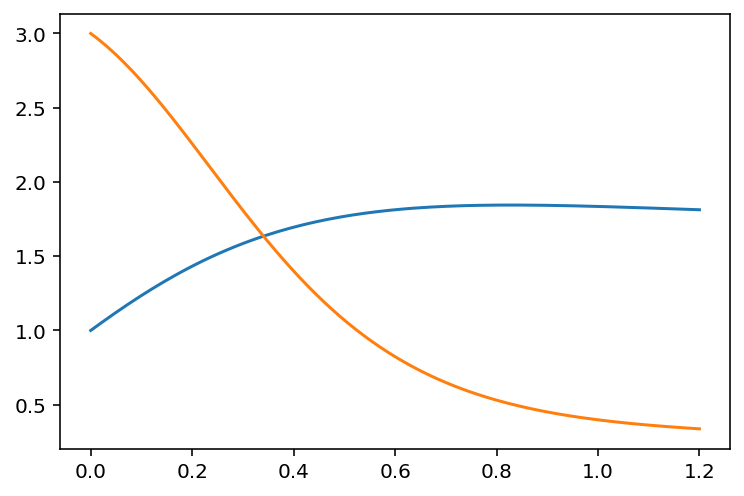

In [14]:
t_extrapolate = jnp.linspace(0, 1.2, 150).reshape(-1, 1)
prediction_extrapolate = vanilla_PiNN.v_predict(NN, t_extrapolate, u0, [t_extrapolate[0], t_extrapolate[-1]])

plt.plot(t_extrapolate, prediction_extrapolate);

In [15]:
vanilla_PiNN.compute_loss(NN, t_extrapolate, u0, [t_extrapolate[0], t_extrapolate[-1]], F)

DeviceArray(308.93341399, dtype=float64)

The residual is large = poor extrapolator.